## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - Drifters

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [108]:
from erddapy import ERDDAP
import numpy as np
import datetime
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")
import pandas as pd

server_url='http://akutan.pmel.noaa.gov:8080/erddap'
# The NRT data is being tested on Akutan, but also available on downdraft
#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [32]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='argos'))

In [33]:
argos = df['Dataset ID'].values
print(argos)

['2018_Argos_Drifters_NRT']


In [34]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [35]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]

In [36]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['trajectory_id']) 
common_variables

{'latitude', 'longitude', 'sst', 'strain', 'time', 'trajectory_id', 'voltage'}

In [37]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)



http://akutan.pmel.noaa.gov:8080/erddap/tabledap/2018_Argos_Drifters_NRT.csv?strain,longitude,trajectory_id,sst,time,voltage,latitude&longitude>=0&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1420848000.0&time<=1547078400.0


In [38]:
from requests.exceptions import HTTPError

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({arfloat: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

2018_Argos_Drifters_NRT


In [76]:
for float, df in dfs.items():
    id_list = list(df.groupby('trajectory_id').groups.keys())
    id_str_list=[str(x).lstrip() for x in id_list]
    print(float, "\n\t" + "\n\t".join(id_str_list))
    


2018_Argos_Drifters_NRT 
	136863
	136866
	136867
	136868
	139910
	139911
	139912
	139913
	139914
	139915
	145469
	145473
	145474
	145480
	148276


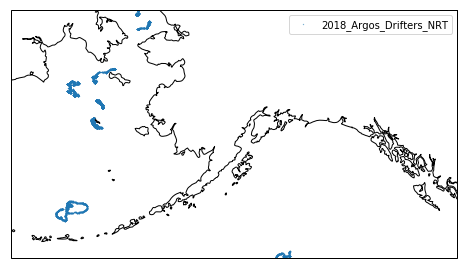

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 66]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Testing gmt-python as alternative plotting platform over cartopy or basemap

In [78]:
import gmt

In [79]:
fig = gmt.Figure()

fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [83]:
dfg = dfs['2018_Argos_Drifters_NRT'].groupby('trajectory_id')


In [86]:
#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray','white']
count=0
for traj in dfg.groups.keys():
    fig.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red
black
blue
green
cyan
yellow
orange
lightred
lightgray
lightblue
lightgreen
lightyellow
brown
darkgray
white


### Show by ID

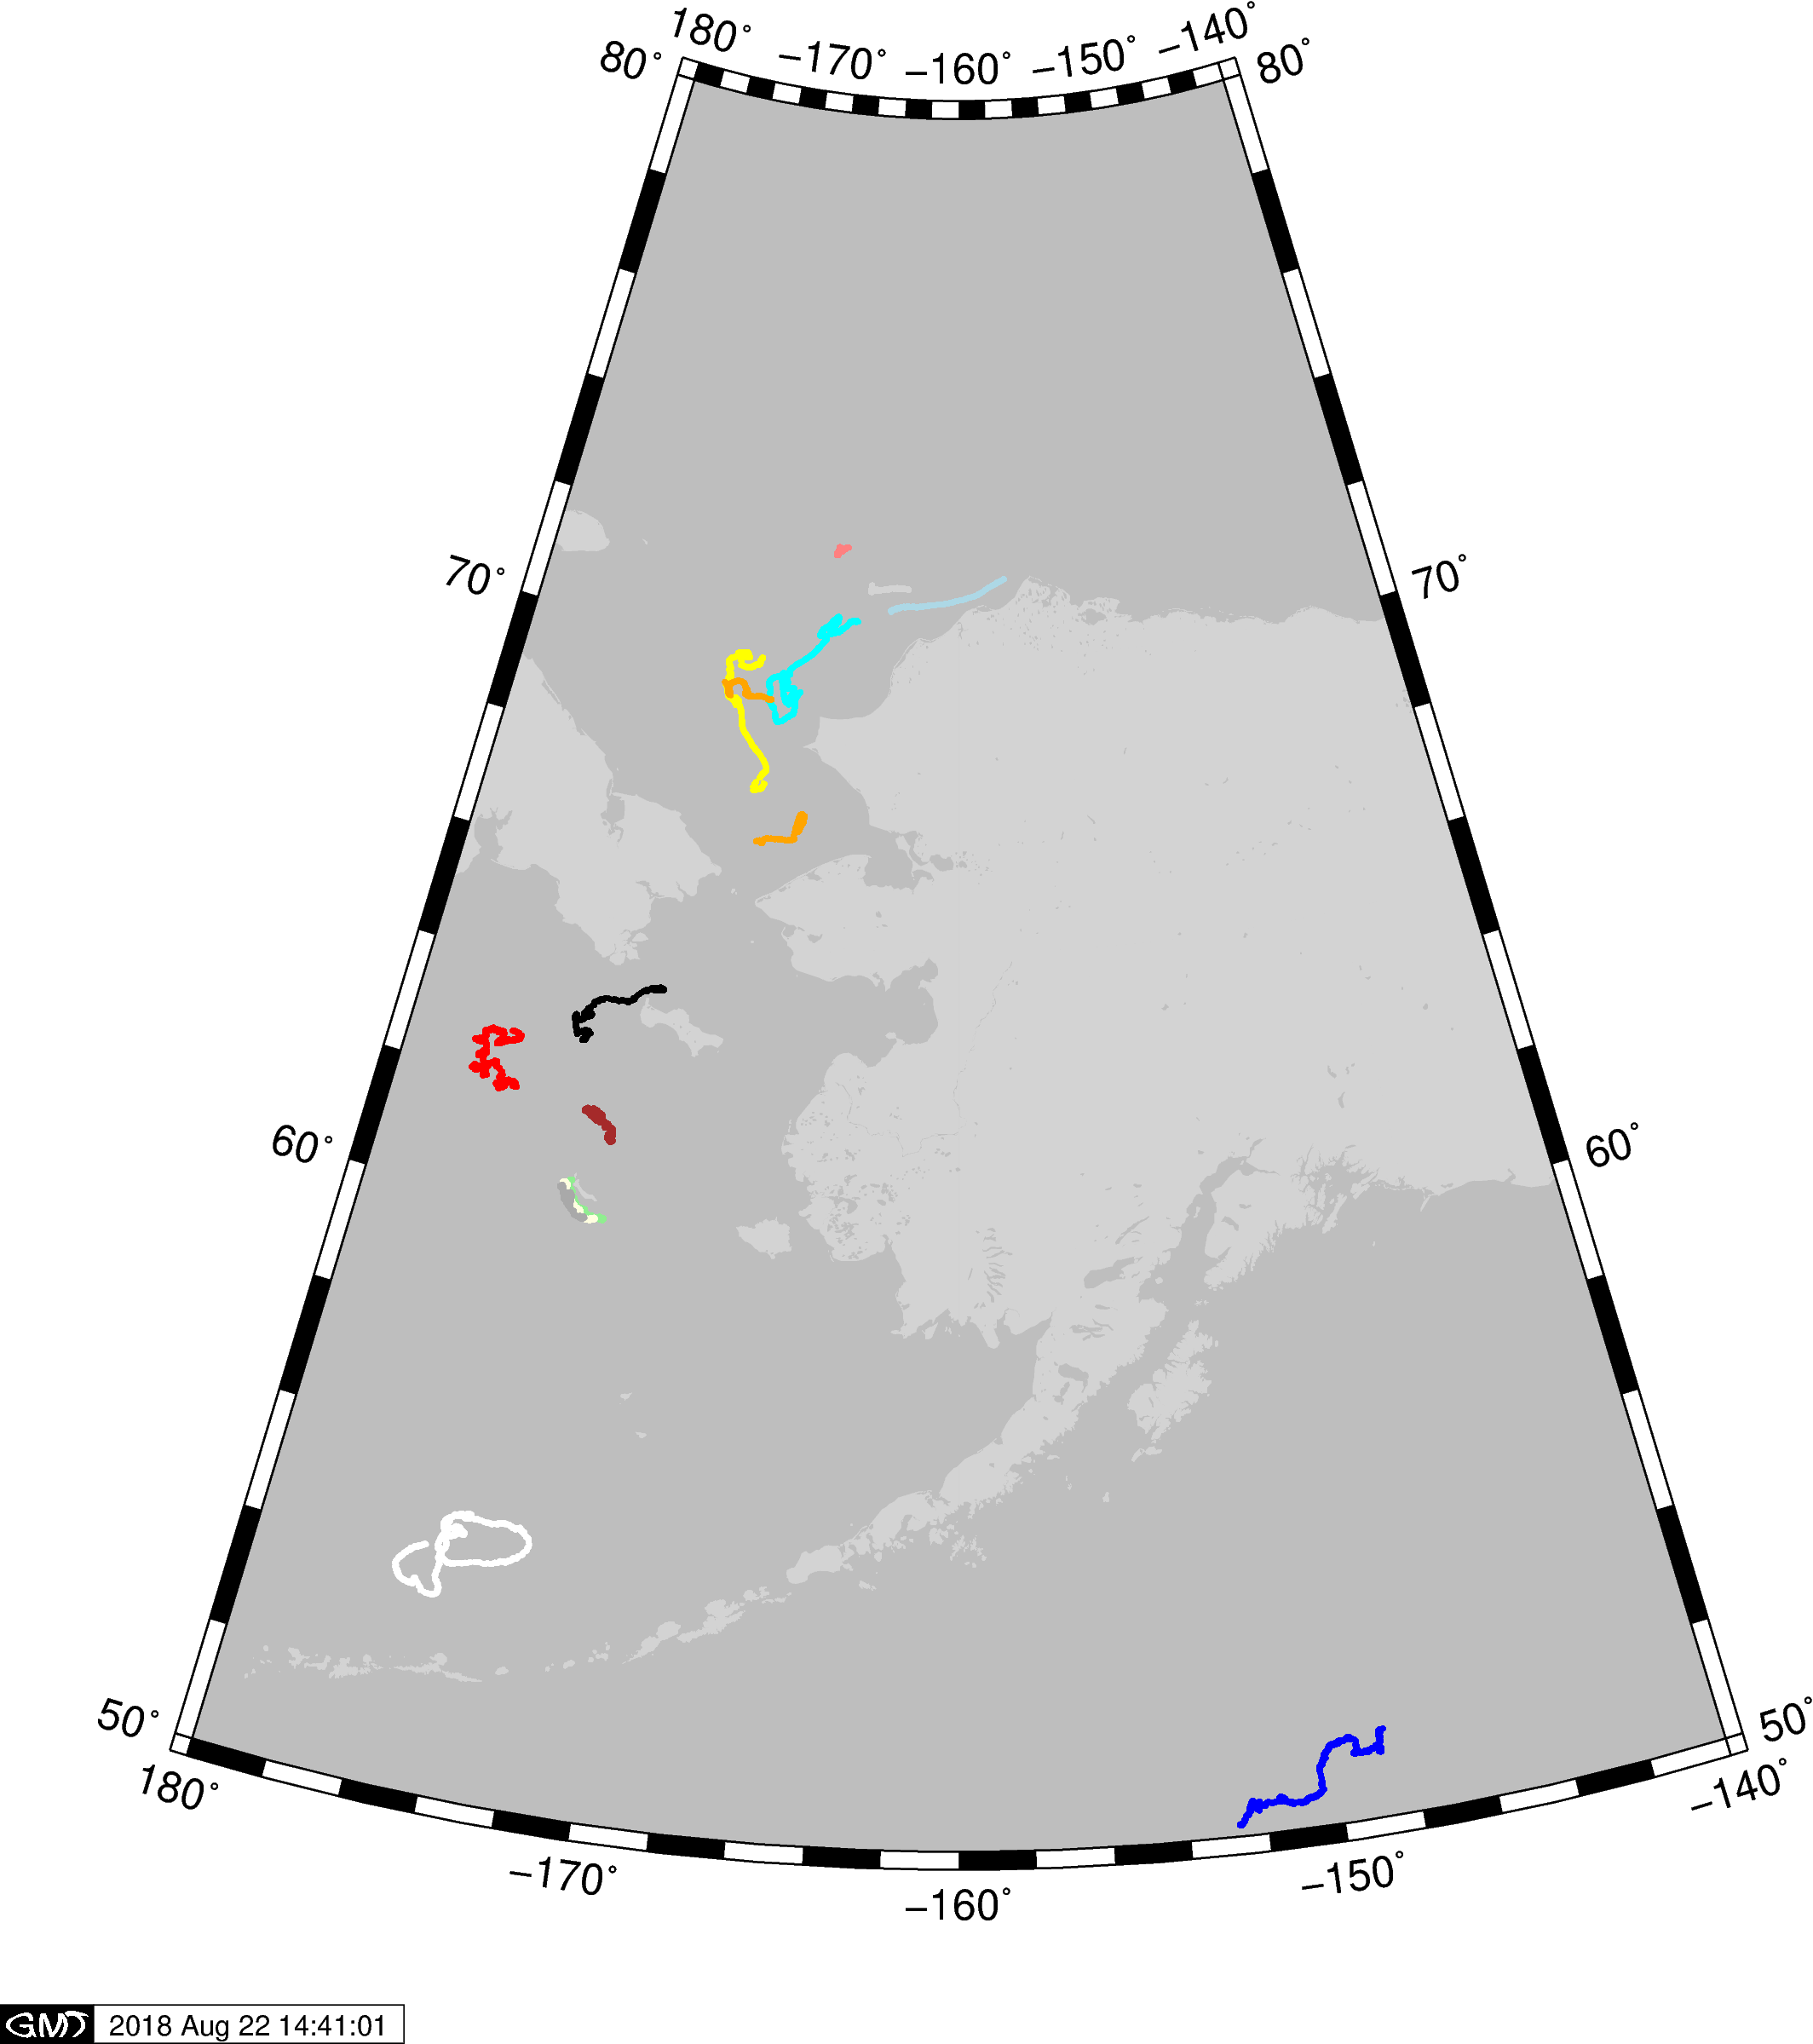

In [87]:
fig.show()

In [90]:
fig1 = gmt.Figure()

fig1.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

Using the cmocean colormaps for gmt found at http://soliton.vm.bytemark.co.uk/pub/cpt-city/cmocean/ (these must be installed in the {conda}/{gmt_env}/share/gmt/cpt/ path where conda is the path to your conda installation and gmt_env is the environment gmt is running in)

### Show by SST

In [91]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


/Users/bell/anaconda2/envs/gmt-python_v2/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


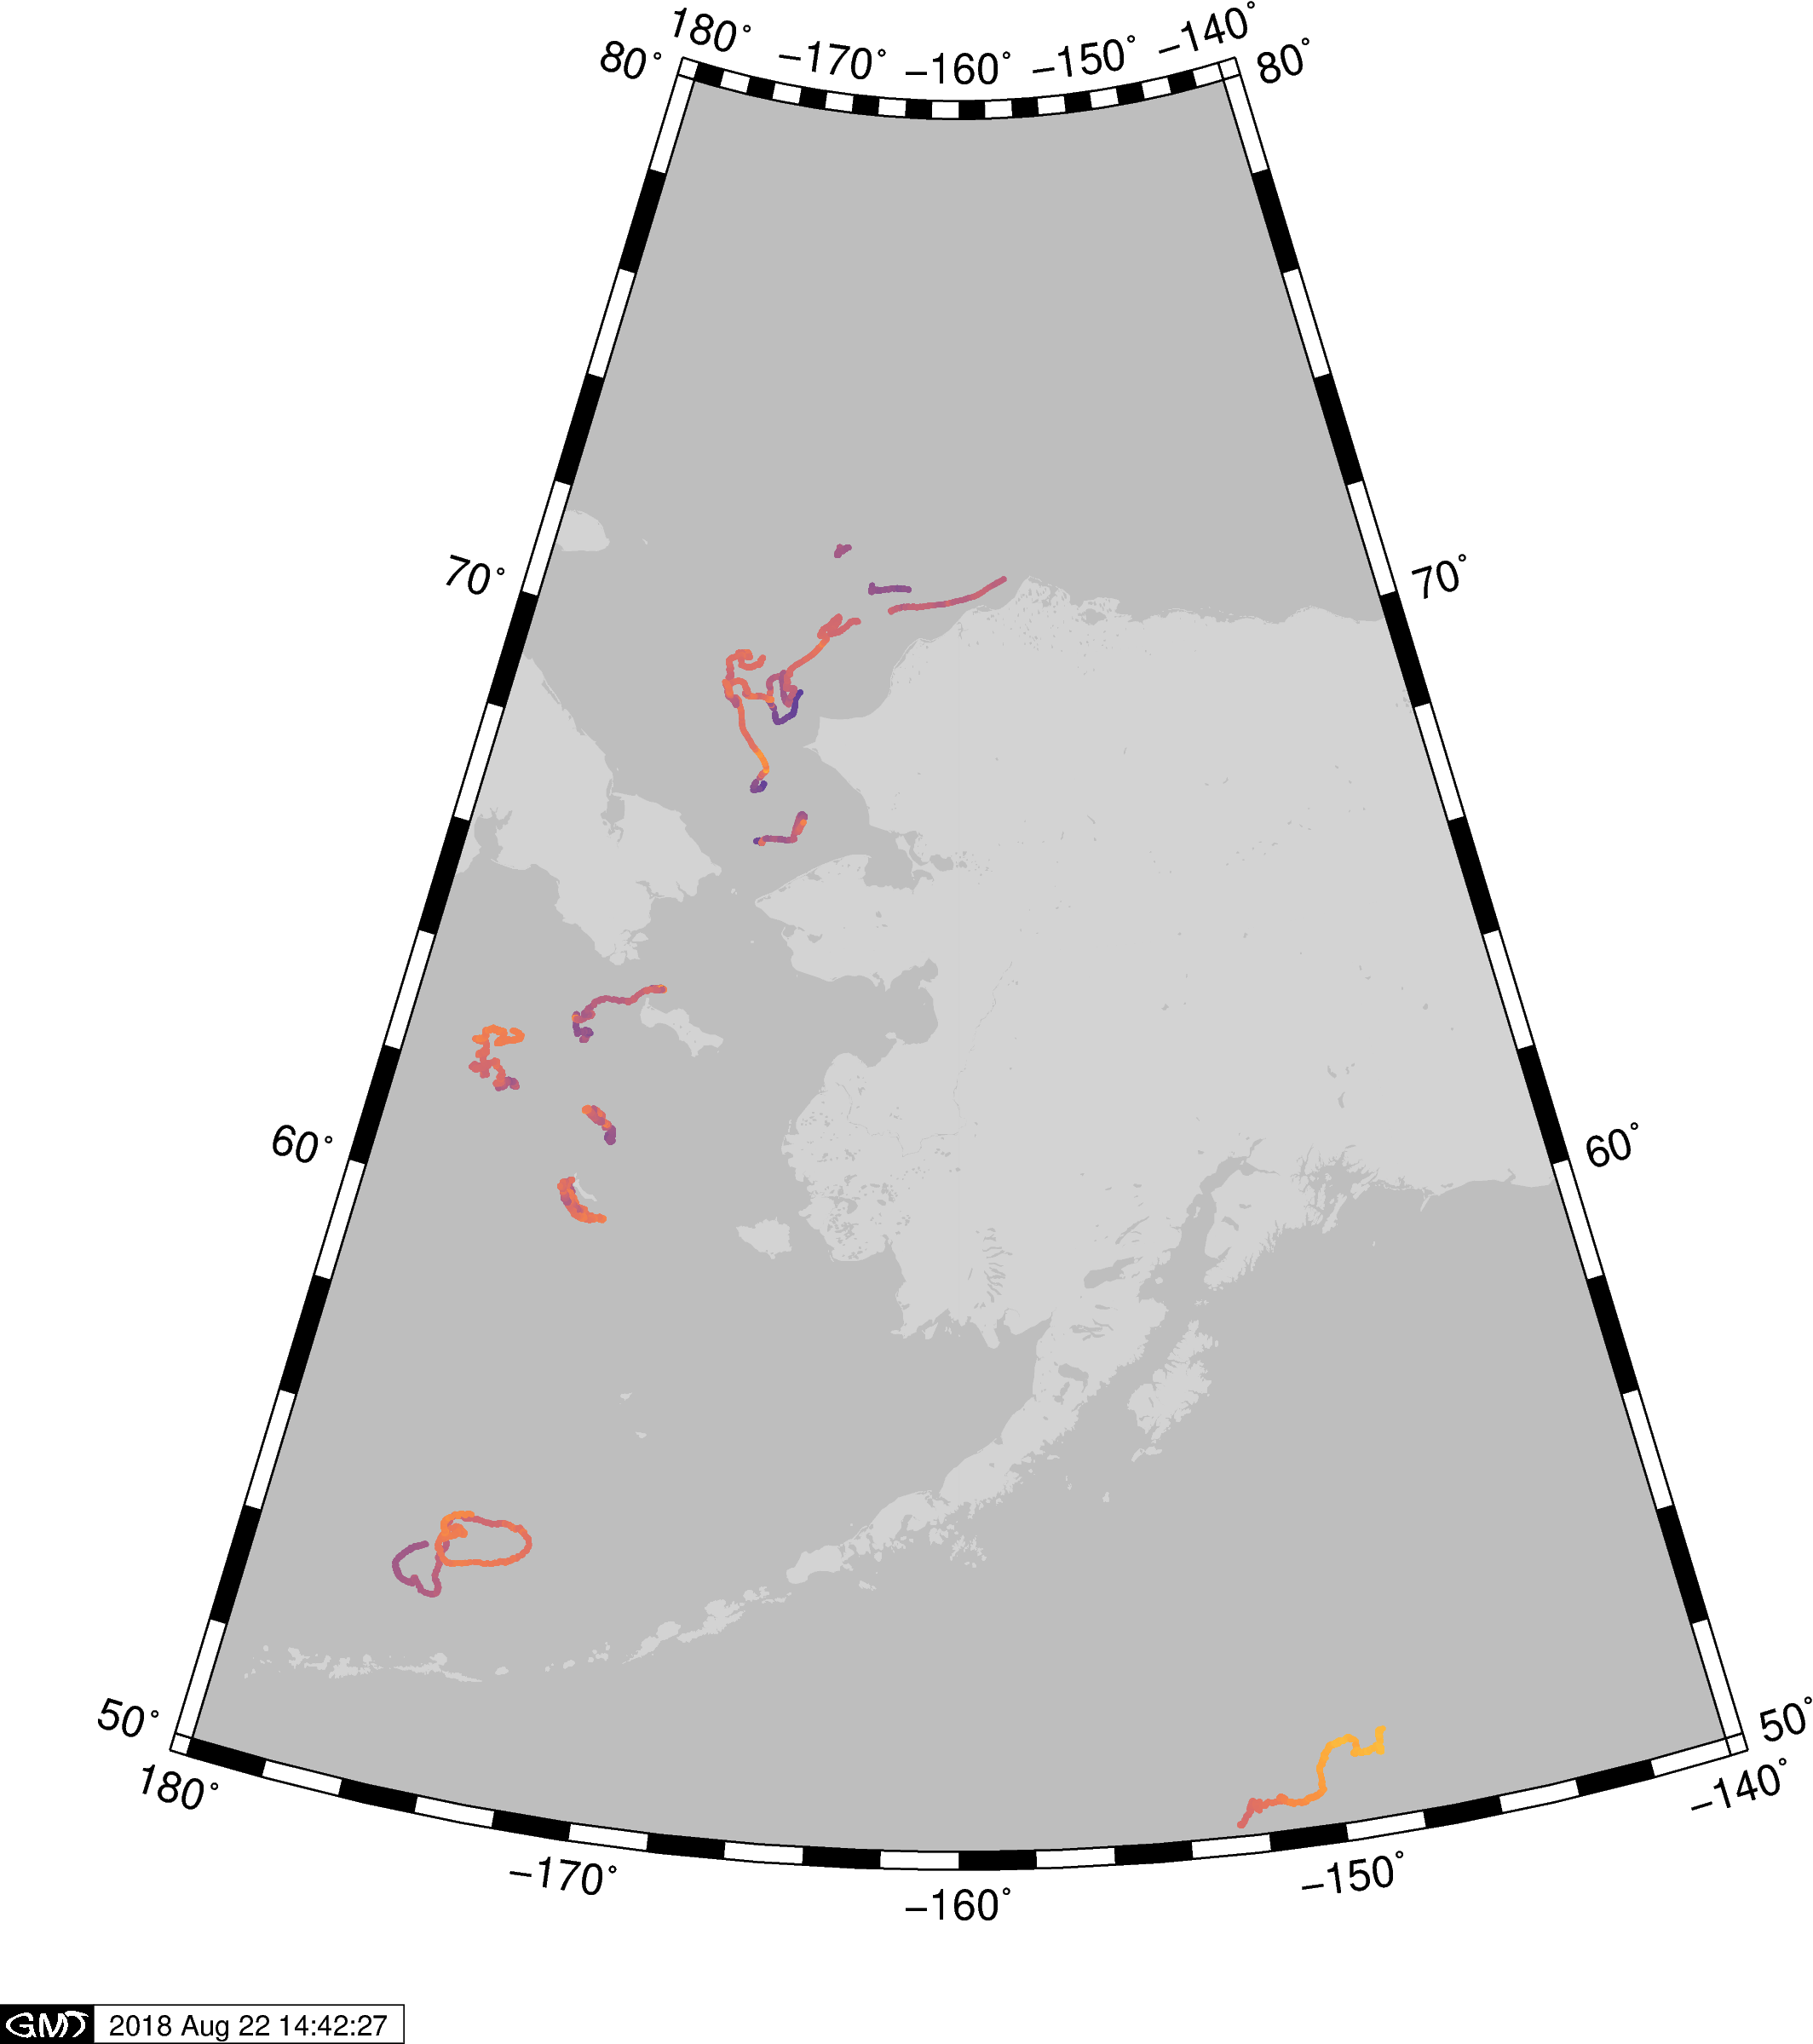

In [92]:
fig1.show()

### Zoom in to Basins (Arctic and Bering) - SST

In [101]:
fig1 = gmt.Figure()
fig1.coast(region=[-175, -155, 65, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

fig1b = gmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [102]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')
    fig1b.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


/Users/bell/anaconda2/envs/gmt-python_v2/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


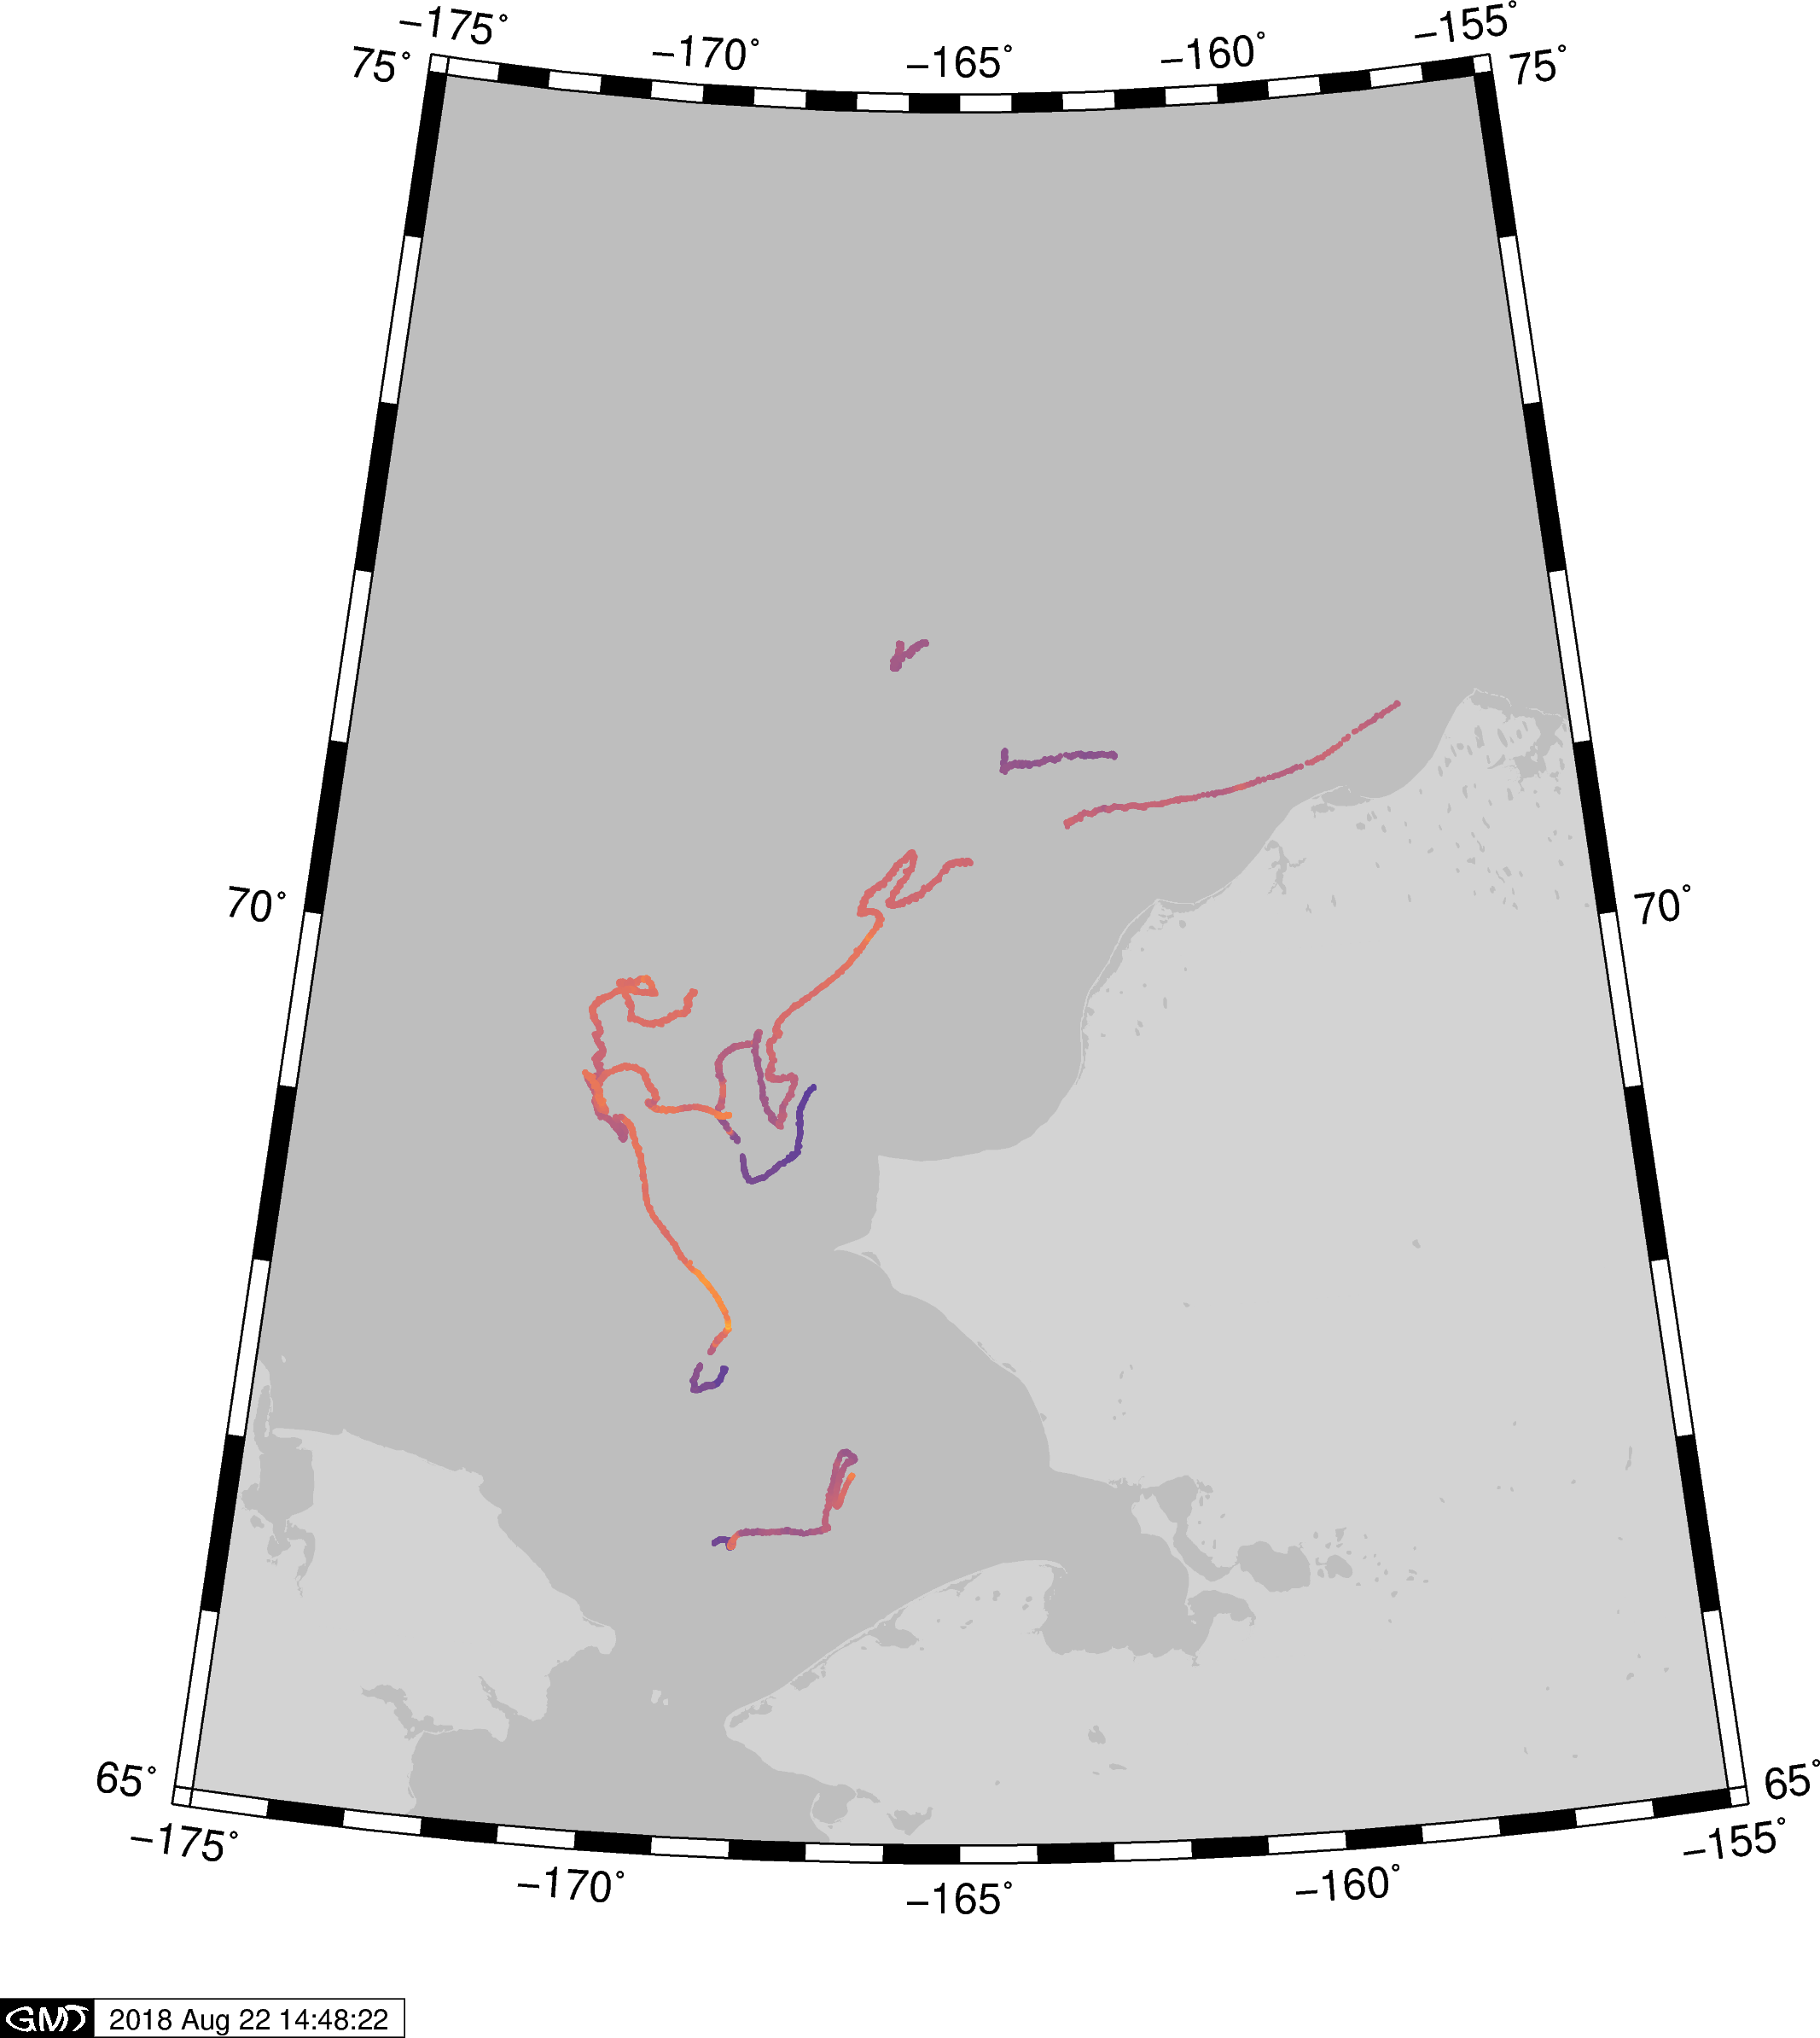

In [103]:
fig1.show()

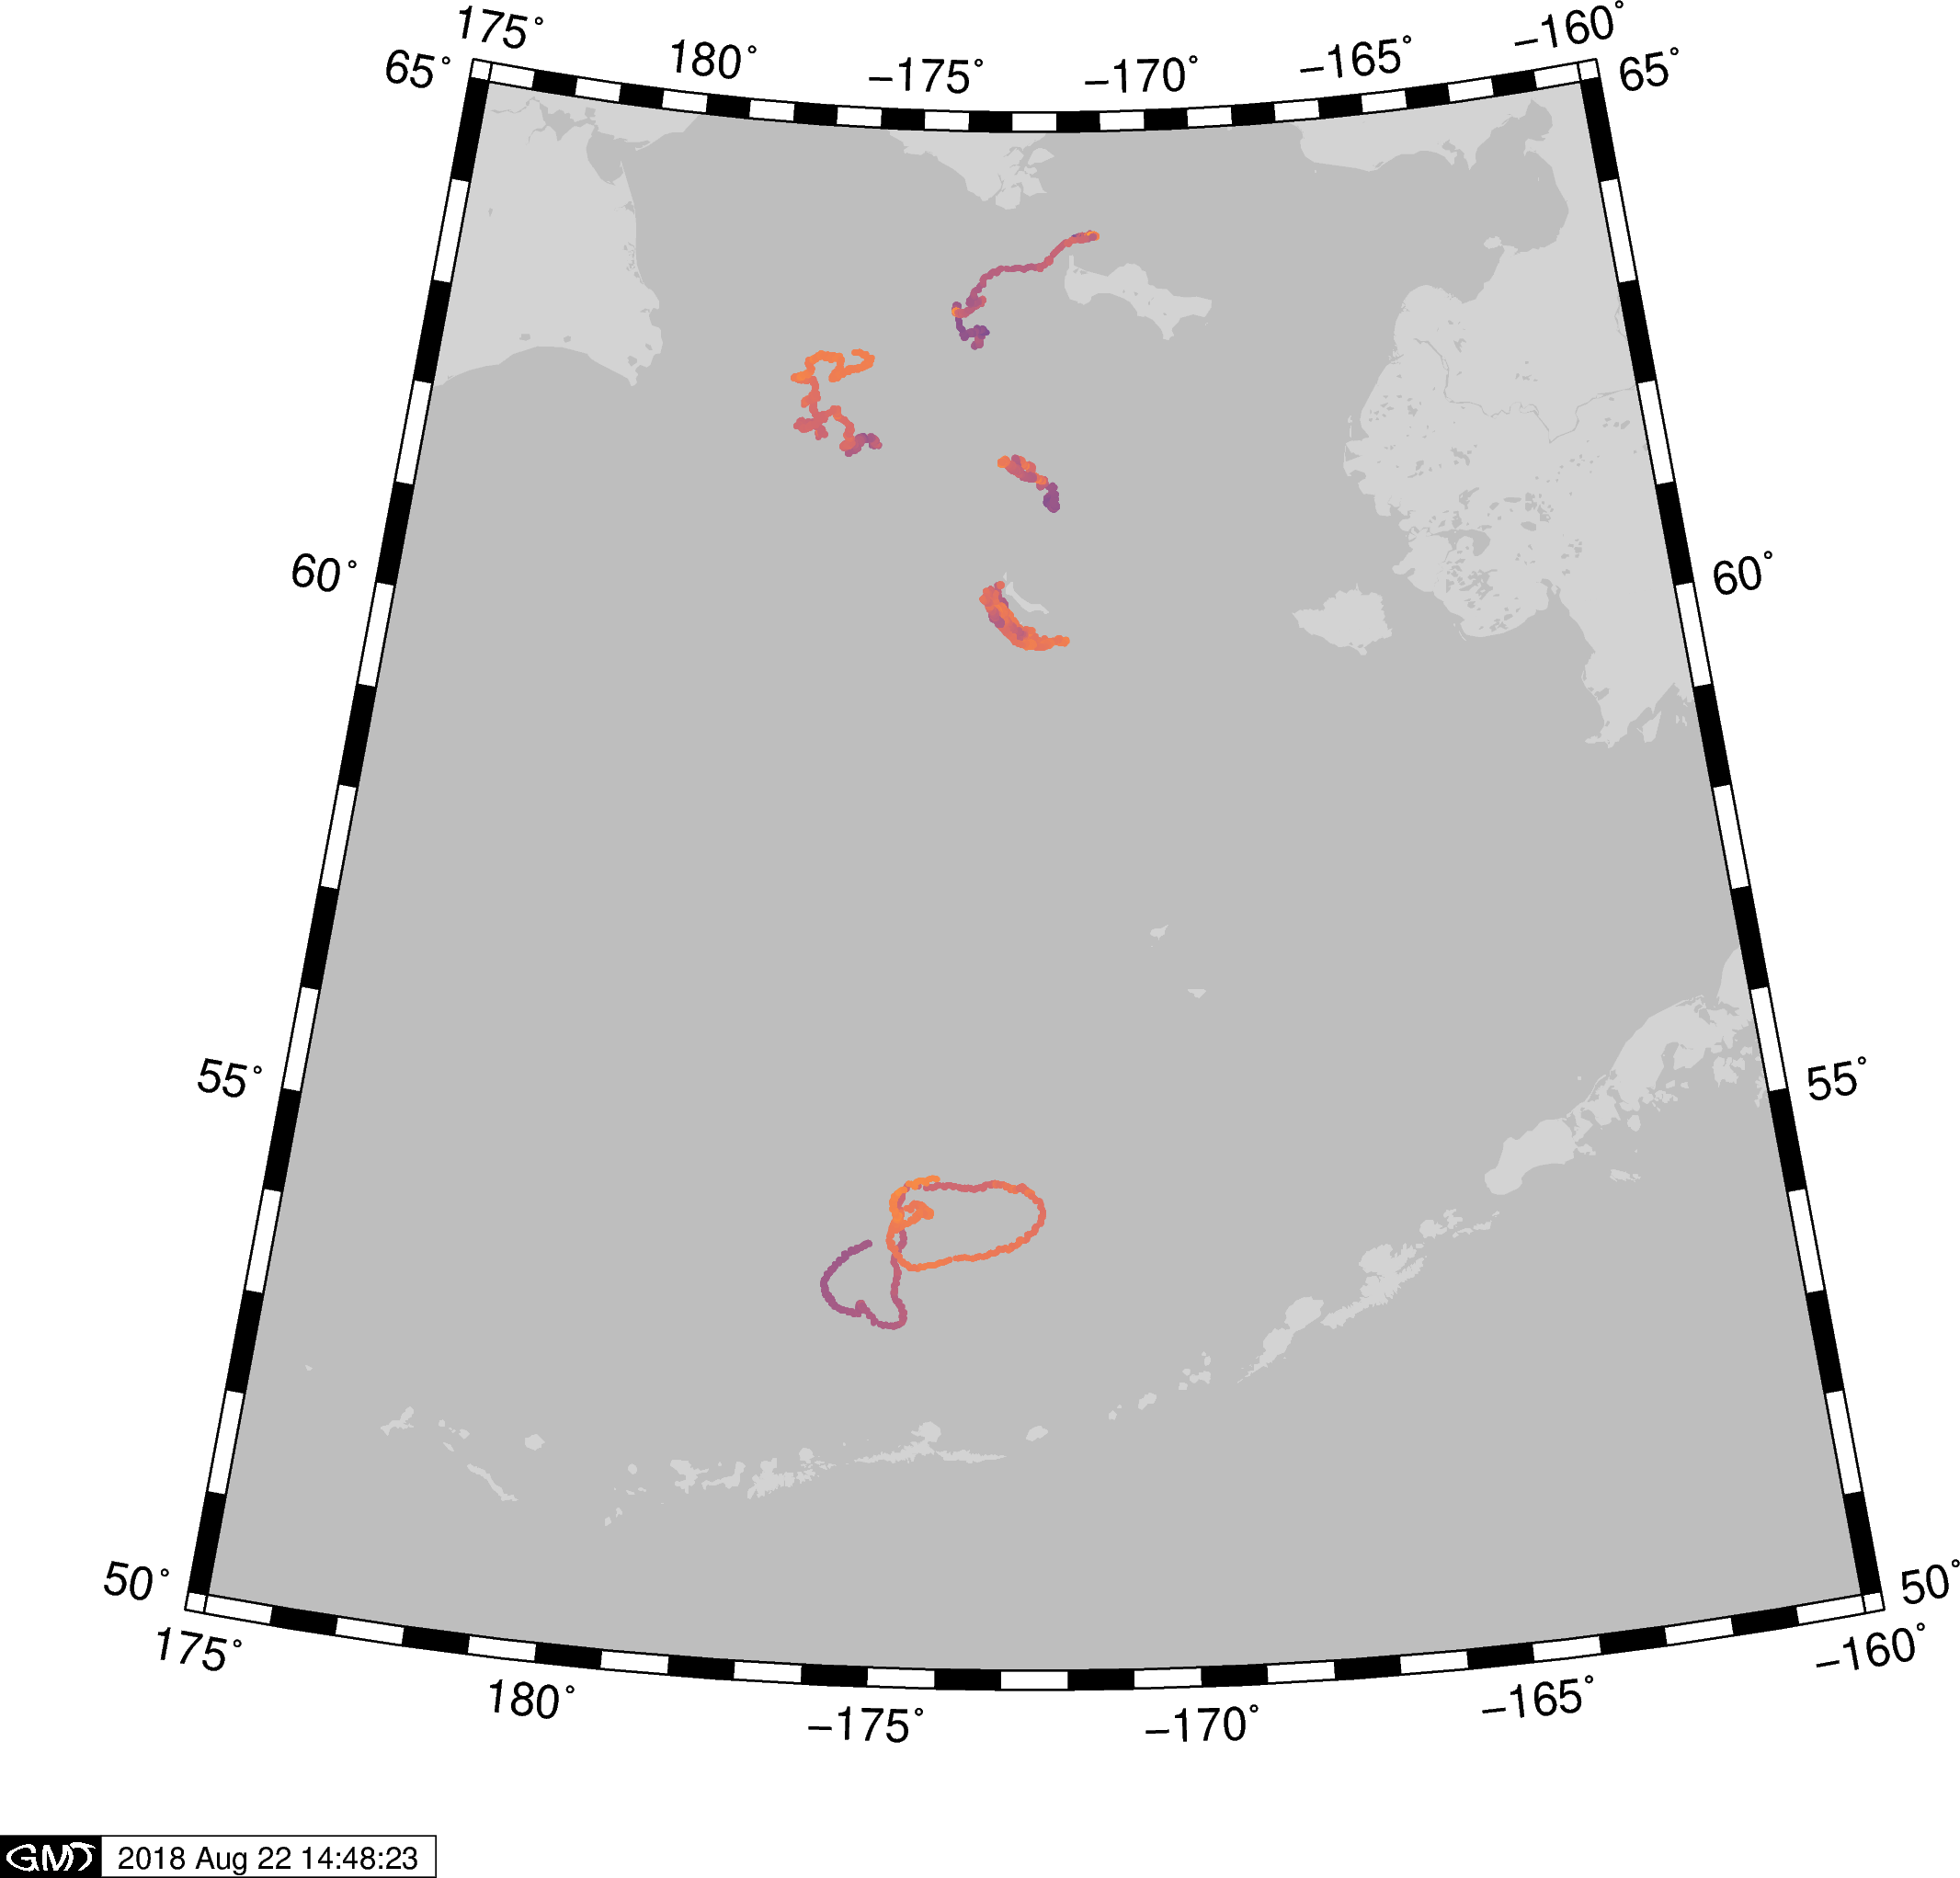

In [104]:
fig1b.show()

### Zoom in to Basins (Arctic and Bering) - DOY

In [165]:
fig1 = gmt.Figure()
fig1.coast(region=[-175, -155, 65, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

fig1b = gmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [166]:
#color by doy
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss['dayofyear'] = dfmiss.index.dayofyear
    dfmiss['dayofyear'].loc[(df.index.dayofyear < 0) | (df.index.dayofyear > 366)] = np.nan
    # normalize data for colormap
    dfmiss['norm'] = dfmiss['dayofyear'].apply(lambda x: (x - (0)) / (366 - (0)))
    #plot a small '+' on mondays for data at '00'
    m_ind = (dfmiss.index.weekday_name == "Monday") & (dfmiss.index.hour == 0)
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfmiss['norm'], cmap='phase', style='c0.05c')
    fig1.plot(x=dfmiss[m_ind].longitude, y=dfmiss[m_ind].latitude, color='black', style='+0.25c')
    fig1b.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfmiss['norm'], cmap='phase', style='c0.05c')
    fig1b.plot(x=dfmiss[m_ind].longitude, y=dfmiss[m_ind].latitude, color='black', style='c0.05+')


/Users/bell/anaconda2/envs/gmt-python_v2/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


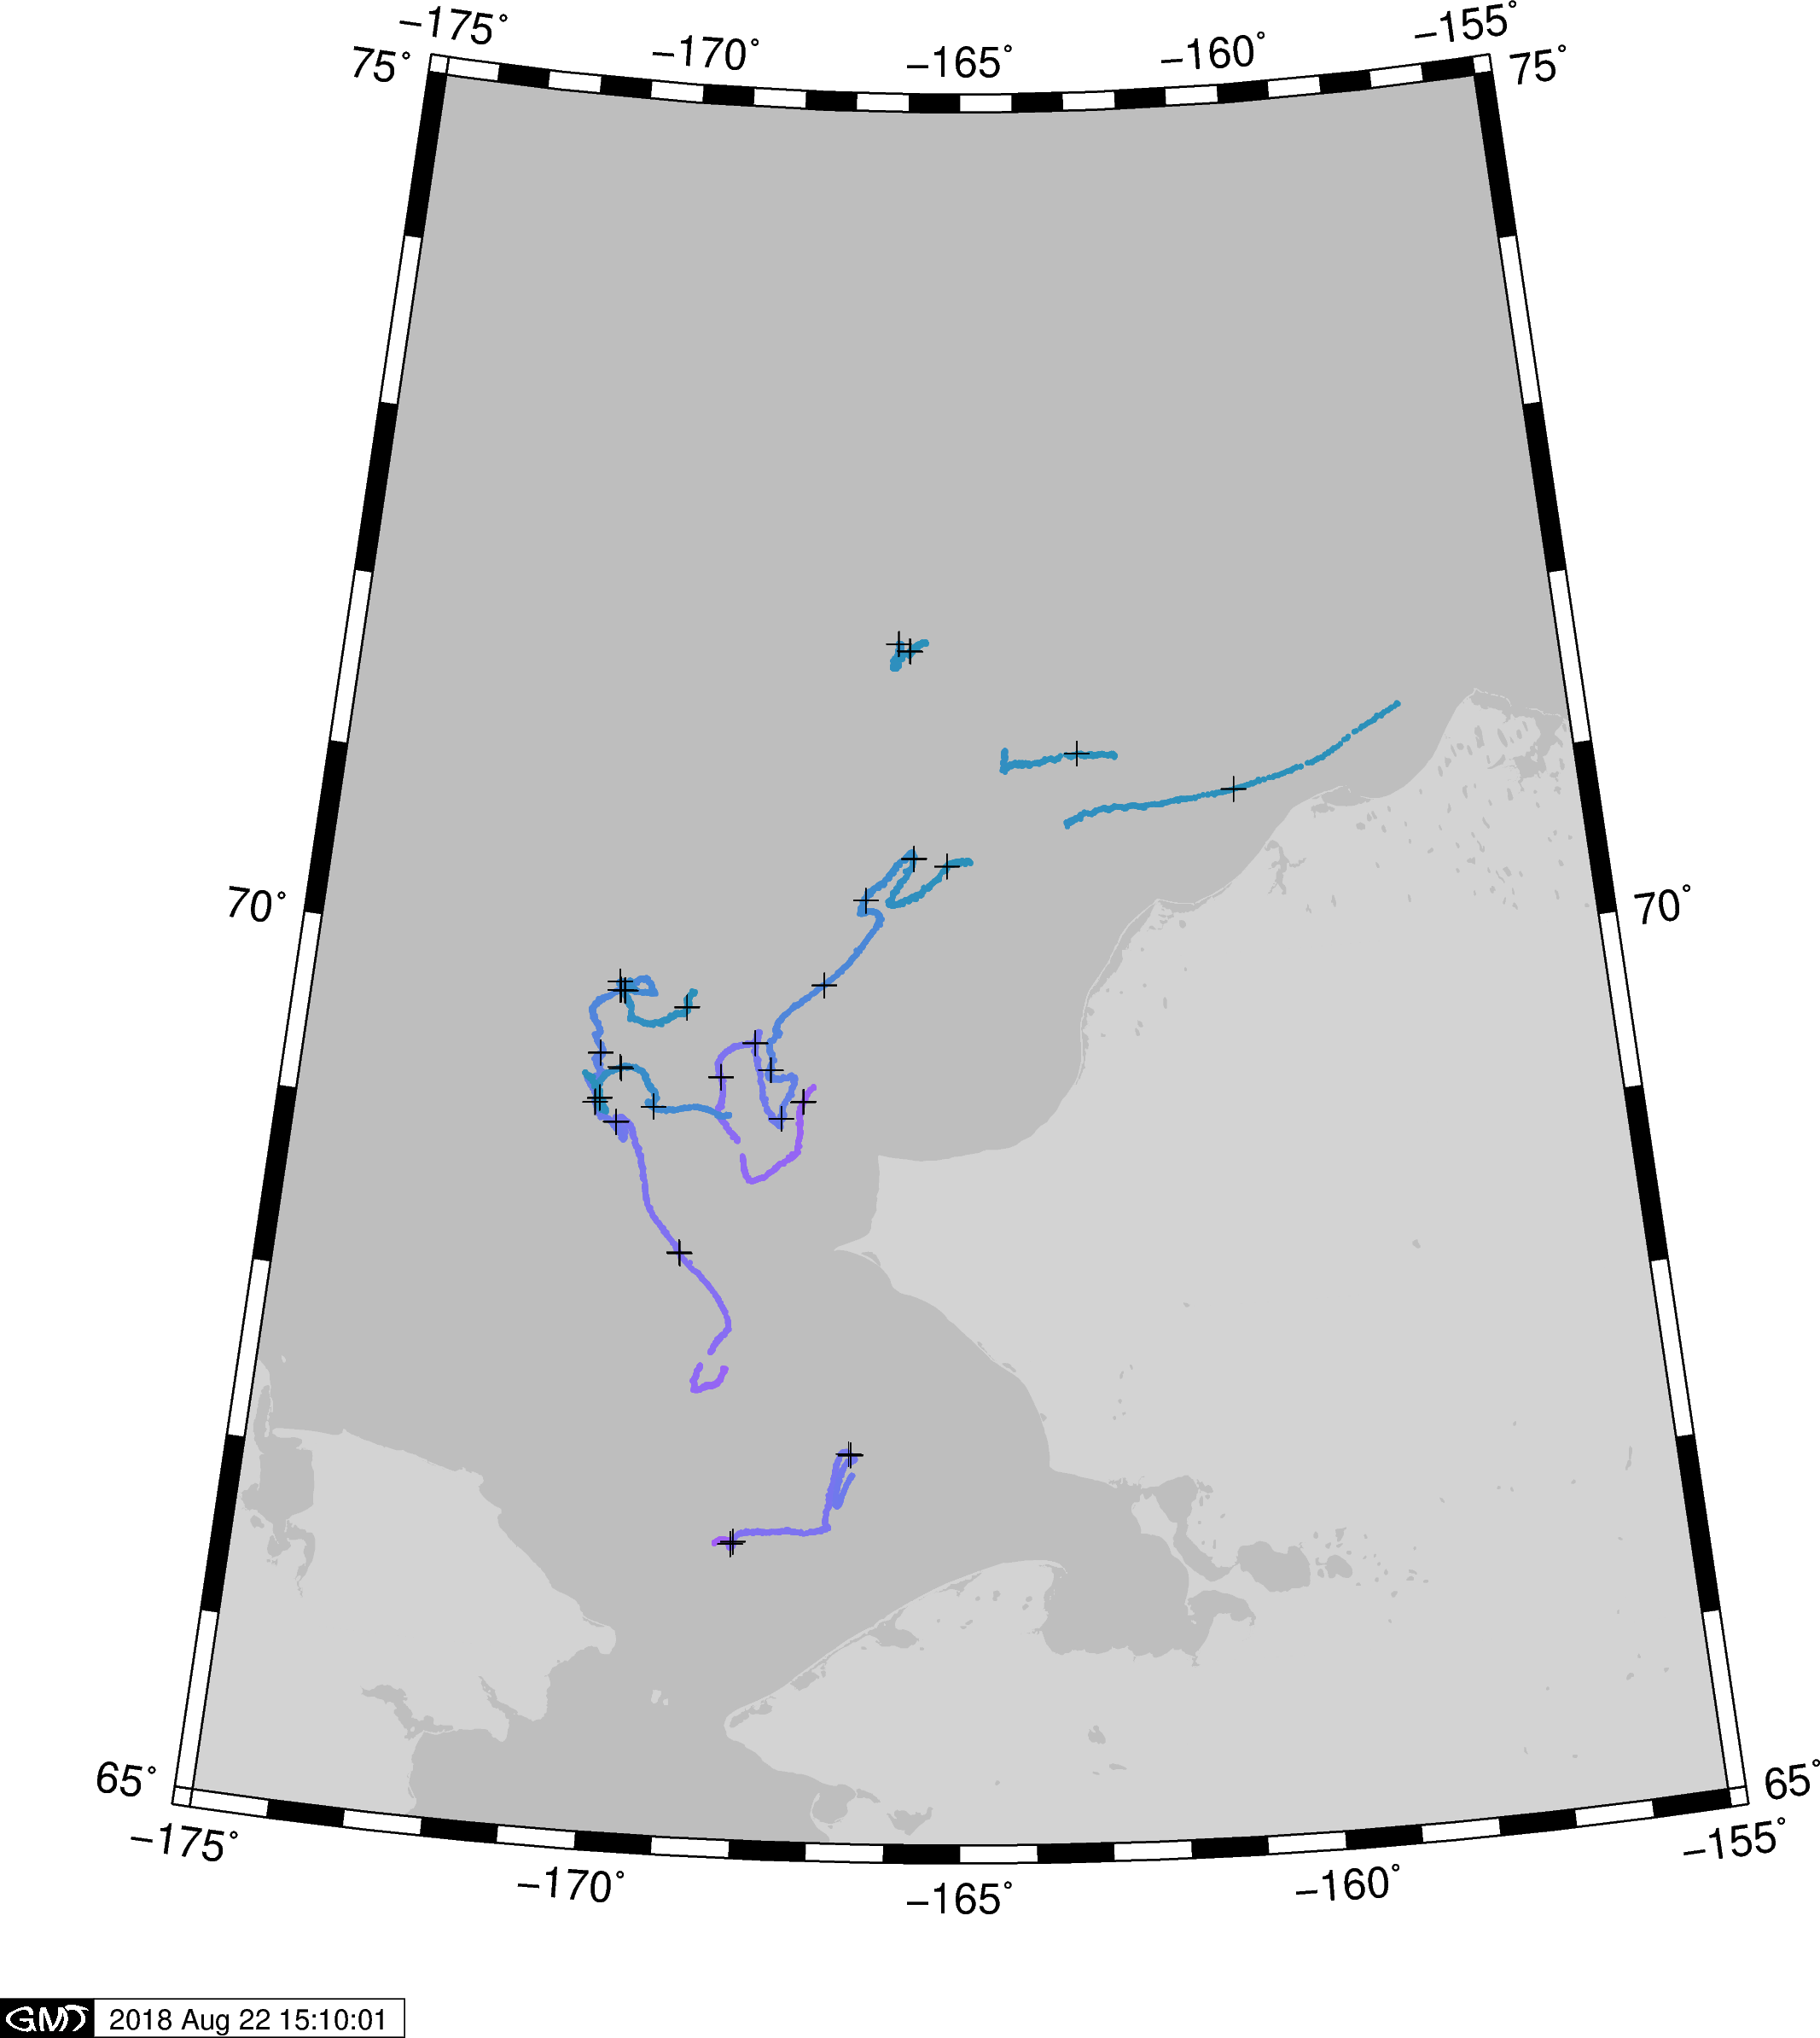

In [167]:
fig1.show()

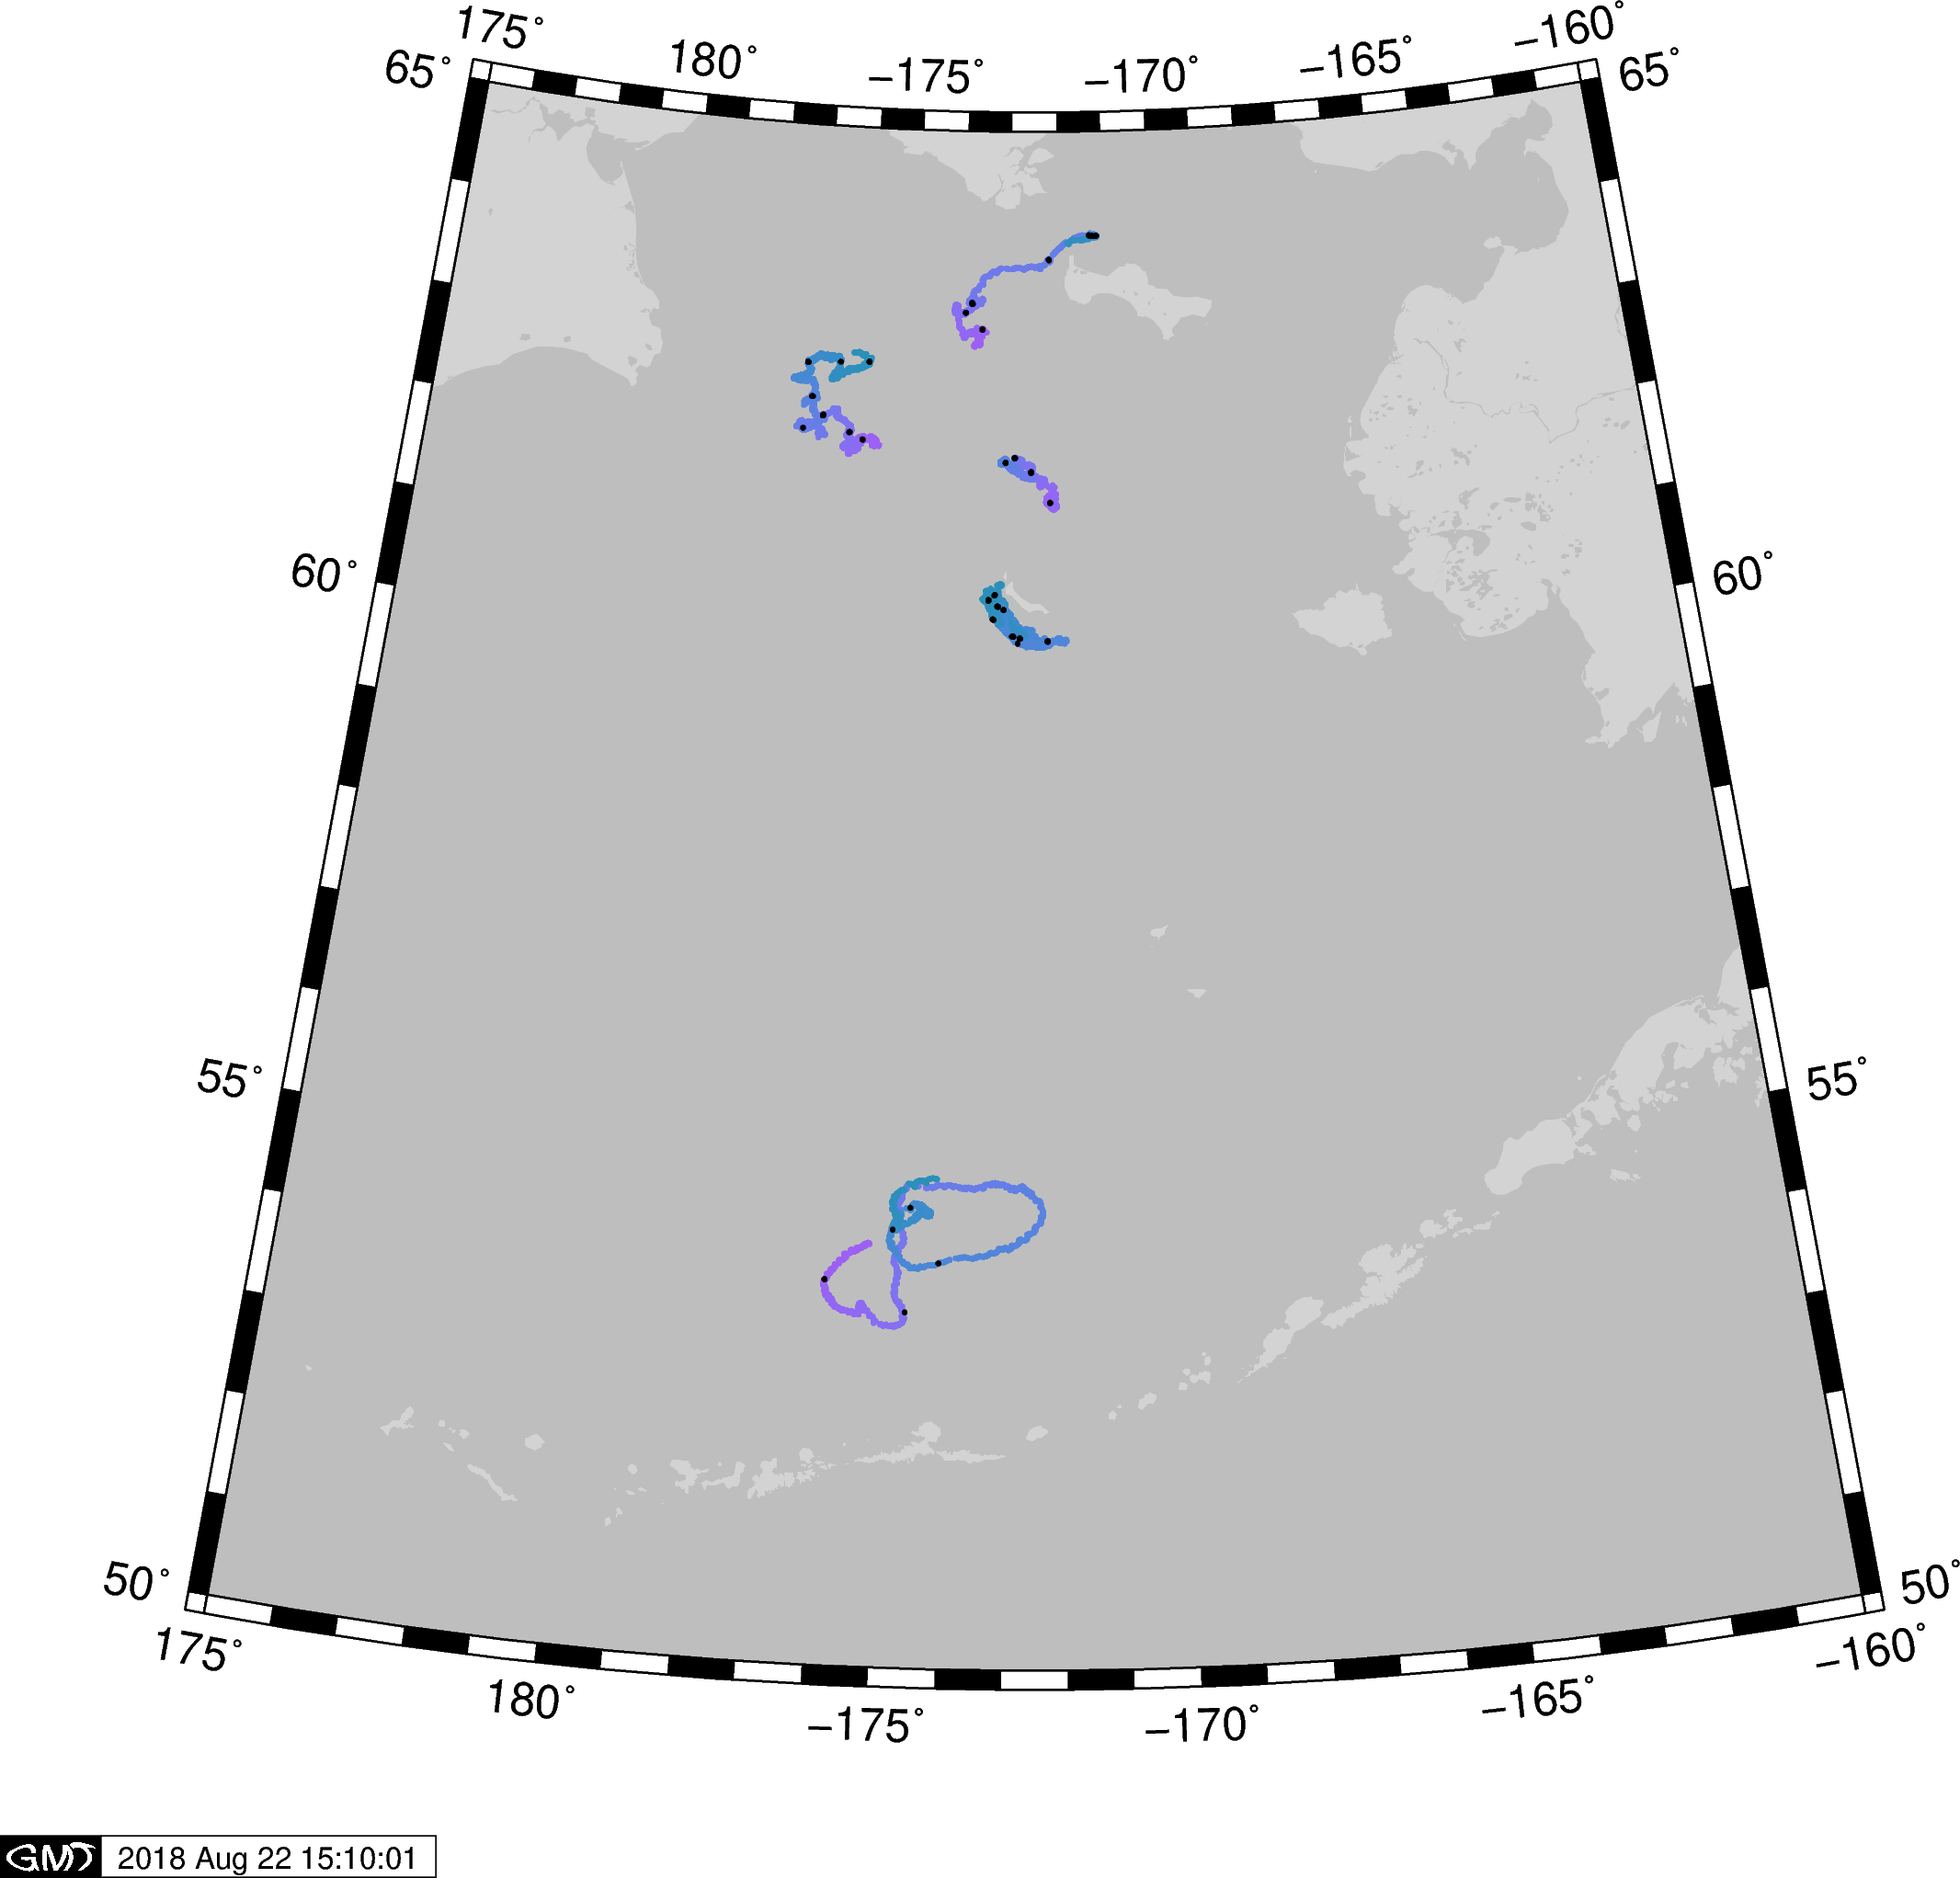

In [169]:
fig1b.show()

array([ True,  True,  True, ..., False, False, False])